In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed.
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np  # Linear algebra routines;
import pandas as pd # Data-frame processing, CSV file I/O (e.g. pd.read_csv);

# Load the StellarGraph library;
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator, GraphSAGELinkGenerator
from stellargraph.layer import GCN, LinkEmbedding, GAT, GraphSAGE
from stellargraph.utils import plot_history
from tensorflow import keras
import tensorflow as tf

# Used to load files;
import os

In [92]:
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory;
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output;
print(os.getcwd())

['ppi_v.csv', 'ppi_e_train.csv', 'ppi_e_test.csv']
/home/nicola/high-performance-graph-analytics-2021/graph_ml


In [93]:
# A list of utility functions used below to manipulate/clean data and compute accuracy metrics;

# Preprocess and clean the PPI dataset;
def build_dataframe(input_data: pd.DataFrame, col_name: str, preserve_int_col_name=False) -> pd.DataFrame:
    """
    Given an input DataFrame and a column name, return a new DataFrame in which the column has been cleaned.
    Used to transform features and labels columns from "0;1;1;0" to [0, 1, 1, 0]
    """
    vertices_dict = []
    for i, row_i in input_data.iterrows():
        features = [int(float(x)) for x in row_i[f"{col_name}s"].split(";")]
        
        new_v = {"id": i}
        for j, f in enumerate(features):
            new_v[j if preserve_int_col_name else f"{col_name}_{j}"] = f
        vertices_dict += [new_v]
    res_df = pd.DataFrame(vertices_dict)
    return res_df.set_index("id")

# Compute the F1 score from 2 vectors of binary labels (0, 1), (ground truth and predictions).
# Taken as-is from old Keras source code, before it got removed;
def f1_score(y_true, y_pred) -> float:
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + keras.backend.epsilon())
    return f1_val

In [94]:
# Define graph name;
graph_name = "ppi"

# Read vertex data;
vertices_path = f"./input/{graph_name}_v.csv"
vertices = pd.read_csv(vertices_path, sep=",", index_col="id")
vertices.drop(["dataset"], axis=1, inplace=True)
vertices = build_dataframe(vertices, "feature")
vertices.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [95]:
# Read edges data (training data);
edge_path = f"./input/{graph_name}_e_train.csv"
edges = pd.read_csv(edge_path, sep=",", index_col=None)
edges.head()

,source,dest
0,0,372
1,0,1101
2,0,766
3,1,640
4,1,1


In [96]:
# Build input graph from vertices and edges (training data) dataframes;
ppi_graph = StellarGraph(
    nodes={"protein": vertices},
    edges={"interaction": edges},
    source_column="source",
    target_column="dest"
    )
print(ppi_graph.info())

# Multigraph: there can be multiple edges between vertices -> Hint: most likely noise, it does not make much sense to have multiple edges here;
# Vertex features: float32 -> Maybe it should be int/bool?

StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 736845

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [736845]
        Weights: all 1 (default)
        Features: none


In [97]:
# Split the input graph into a train and validation graphs 
edge_splitter_validation = EdgeSplitter(ppi_graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from ppi_graph, 
# Obtain the reduced graph graph_valid with the sampled links removed
# edges_validation and validation are employed as ground truth for testing the model;
graph_validation, edges_validation, labels_validation = edge_splitter_validation.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)
print(graph_validation.info())

# "global" -> pick random pairs of vertices to create fake edges ("negative samples")
# "keep_connected" -> Don't remove edges that would disconnect graphs
# p=0.1 -> remove 10% of edges

# graph_validation -> new graph with 10% of edges removed, we use it to create the training set
# edges_validation -> list of edges used for testing. 50% are real, 50% are fake
# labels_validation -> labels that identify real/fake edges in edges_test

** Sampled 73684 positive and 73684 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 663161

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [663161]
        Weights: all 1 (default)
        Features: none


In [98]:
# Build a dataframe to visualize the real/fake edges (not used in the training);
edges_validation_sources = [edges_validation[i][0] for i in range(0, len(edges_validation))]
edges_validation_dests = [edges_validation[i][1] for i in range(0, len(edges_validation))]
edges_validation_df = pd.DataFrame(list(zip(edges_validation_sources, edges_validation_dests, labels_validation)), columns=["source", "dest", "label"])
print(edges_validation_df)

        source   dest  label
0        10508  10843      1
1        21261  21645      1
2        22768  23885      1
3        54024  54244      1
4        43264  43832      1
...        ...    ...    ...
147363   22020  18948      0
147364   49962  27528      0
147365   46809  48040      0
147366   27008  56809      0
147367   53362  25649      0

[147368 rows x 3 columns]


In [99]:
# Here we create a dataset for training, by creating again some fake edges;
# Note: by passing the original "ppi_graph" as well, we guarantee that real edges 
#   that are no longer present in "graph_validation" cannot be created as fake edges.
# This avoids teaching the model that a real edge should be classified as fake.
# Is this a leak? Probably not, but think about it (and test your hypotheses)!
edge_splitter_train = EdgeSplitter(graph_validation, ppi_graph)

# Same as before, create fake edges to use during the training;
graph_train, edges_train, labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)

# Note: you might want to do this step again (at the very beginning) to create a test set not employed during training;

** Sampled 66316 positive and 66316 negative edges. **


In [100]:
# Build training dataframe for explicit visualization;
edges_train_sources = [edges_train[i][0] for i in range(0, len(edges_train))]
edges_train_dests = [edges_train[i][1] for i in range(0, len(edges_train))]
edges_train_df = pd.DataFrame(list(zip(edges_train_sources, edges_train_dests, labels_train)), columns=["source", "dest", "label"])
print(edges_train_df)

        source   dest  label
0        15903  18065      1
1        35037  35208      1
2        21903  22704      1
3        42403  42627      1
4         7810   7922      1
...        ...    ...    ...
132627    6071  34811      0
132628   38310  44580      0
132629   48917  36083      0
132630    3521  15891      0
132631   40015  45695      0

[132632 rows x 3 columns]


In [101]:
# Create a generator on graph_train and make an iterator over the training links.
# This class creates the data fed to the model during the training.
# This is used during the training to extract from the graph all the required information (e.g. vertex features given an edge).
# "gcn" is used to specify how data are preprocessed. Depending on your model of choice, you might need a different option: 
#   https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.FullBatchLinkGenerator
train_gen = FullBatchLinkGenerator(graph_train, method="gcn") 
#train_gen = GraphSAGELinkGenerator(graph_train, batch_size=1024, num_samples=[2, 2], seed=42)
train_flow = train_gen.flow(edges_train, labels_train)

# Same thing, create a LinkGenerator to be used for validation;
validation_gen = FullBatchLinkGenerator(graph_validation, method="gcn")
#validation_gen = GraphSAGELinkGenerator(graph_validation, batch_size=1024, num_samples=[2, 2], seed=32)
validation_flow = validation_gen.flow(edges_validation, labels_validation)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [102]:
# Create a simple GCN model.
# We specify the generator used in the training here!

gcn = GCN(
    layer_sizes=[32, 32, 32, 32, 32], activations=["relu", "relu", "relu", "relu", "relu"], generator=train_gen, dropout=0.3
)

'''
gat = GAT(
    layer_sizes=[32, 16], activations=["relu", "relu"], attn_heads=4, generator=train_gen, in_dropout=0.1, attn_dropout=0.1, normalize='l2'
)
'''
'''
graph_sage = GraphSAGE(
    layer_sizes=[16, 16], activations=["relu", "relu"], dropout=0.3, generator=train_gen # normalize="l2", bias=True
)
'''

# Expose input and output tensors of the GCN model for link prediction;
x_inp, x_out = gcn.in_out_tensors()

# Create the final link embedding layer: 
# - it takes a pair of vertex embeddings produced by the GCN model, 
# - applies a binary operator (ip = inner product) to produce the corresponding link embedding,
# - passes it through a dense layer (if method!="ip") to obtain the wanted embedding dimension

#print(x_inp, x_out)
prediction = LinkEmbedding(activation="linear", method="l2")(x_out)  #method="ip"

prediction = keras.layers.Dense(1, activation="sigmoid")(prediction)
''''''
#print(prediction)
#x_out = x_out[0,:,0,0]
#prediction = keras.layers.Dot(axes=1, normalize=True)([x_out[0,:,0,:], x_out[0,:,1,:]])   #tf.split(x_out, num_or_size_splits=2, axis=2)

#prediction = prediction[0, :, 0, 0]
print(prediction)

# Reshape the predictions from (X, 1) to (X,) to match the shape of targets;
prediction = keras.layers.Reshape((-1,))(prediction)

# Stack the GCN and prediction layers into a Keras model;
model = keras.Model(inputs=x_inp, outputs=prediction)

# Compile the model, specifying the hyperparameters;
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.004),
    loss=keras.losses.binary_crossentropy,               # We do binary classification;
    metrics=[keras.metrics.BinaryAccuracy(), f1_score],  # Also measure binary accuracy and F1 score;
)

KerasTensor(type_spec=TensorSpec(shape=(1, None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")


In [103]:
# Evaluate the initial (untrained) model on the train and validation sets, to get baseline scores;
init_train_metrics = model.evaluate(train_flow)
init_valid_metrics = model.evaluate(validation_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_valid_metrics):
    print("\t{}: {:0.4f}".format(name, val))

# If you get F1=0, it's likely that everything is predicted as false and Recall is 0;

1/1 [==============================] - 0s 351ms/step - loss: 0.6931 - binary_accuracy: 0.4930 - f1_score: 0.6512

Train Set Metrics of the initial (untrained) model:
	loss: 0.6931
	binary_accuracy: 0.4941
	f1_score: 0.6514

Validation Set Metrics of the initial (untrained) model:
	loss: 0.6931
	binary_accuracy: 0.4930
	f1_score: 0.6512


In [104]:
# Set the number of training epochs;
epochs = 175

# Train the model (here, we specify the validation set);
history = model.fit(
    train_flow, epochs=epochs, validation_data=validation_flow, verbose=2, shuffle=False
)

Epoch 1/175
1/1 - 2s - loss: 0.6931 - binary_accuracy: 0.5110 - f1_score: 0.6496 - val_loss: 0.6930 - val_binary_accuracy: 0.5300 - val_f1_score: 0.1424 - 2s/epoch - 2s/step
Epoch 2/175
1/1 - 1s - loss: 0.6930 - binary_accuracy: 0.5302 - f1_score: 0.1485 - val_loss: 0.6927 - val_binary_accuracy: 0.6025 - val_f1_score: 0.6010 - 1s/epoch - 1s/step
Epoch 3/175
1/1 - 1s - loss: 0.6927 - binary_accuracy: 0.6004 - f1_score: 0.6020 - val_loss: 0.6921 - val_binary_accuracy: 0.5231 - val_f1_score: 0.6499 - 956ms/epoch - 956ms/step
Epoch 4/175
1/1 - 1s - loss: 0.6921 - binary_accuracy: 0.5341 - f1_score: 0.6568 - val_loss: 0.6910 - val_binary_accuracy: 0.5941 - val_f1_score: 0.6170 - 1s/epoch - 1s/step
Epoch 5/175
1/1 - 1s - loss: 0.6910 - binary_accuracy: 0.5907 - f1_score: 0.6155 - val_loss: 0.6893 - val_binary_accuracy: 0.6009 - val_f1_score: 0.6047 - 923ms/epoch - 923ms/step
Epoch 6/175
1/1 - 1s - loss: 0.6895 - binary_accuracy: 0.5996 - f1_score: 0.6040 - val_loss: 0.6867 - val_binary_accur

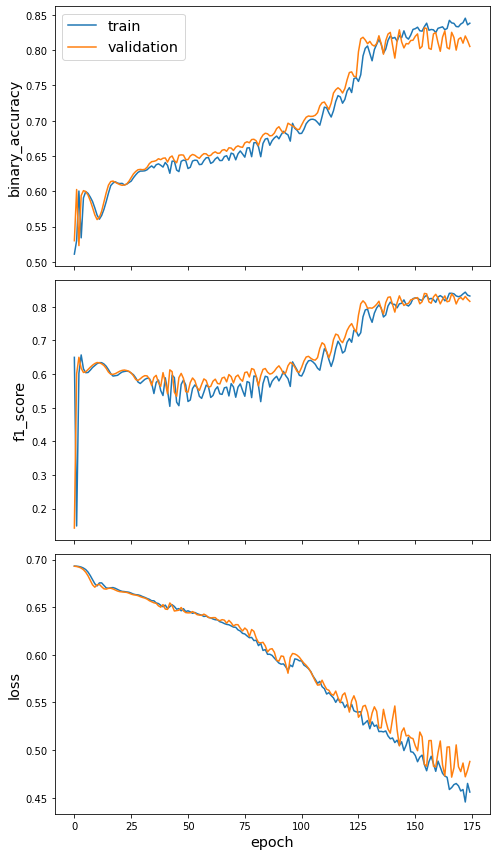

In [105]:
# Plot the training history
plot_history(history)

# Accuracy oscillates, and train and validation are close -> This indicates a high learning rate, and an incomplete training (underfitting);

In [106]:
# Evaluate the trained model on the train and validation sets: 
train_metrics = model.evaluate(train_flow)
validation_metrics = model.evaluate(validation_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 282ms/step - loss: 0.4881 - binary_accuracy: 0.8052 - f1_score: 0.8160

Train Set Metrics of the trained model:
	loss: 0.4770
	binary_accuracy: 0.8123
	f1_score: 0.8214

Validation Set Metrics of the trained model:
	loss: 0.4881
	binary_accuracy: 0.8052
	f1_score: 0.8160


In [107]:
# Read edges data (test data)
edge_path = f"./input/{graph_name}_e_test.csv"
edges_test = pd.read_csv(edge_path, sep=",", index_col=None)

# Delete duplicated edges, if they exist;
edges_test = edges_test.drop_duplicates().reset_index(drop=True)

# Extract numpy arrays for test examples;
examples_test = edges_test.to_numpy()

edges_test.head()

,source,dest
0,29842,56942
1,19107,10249
2,53567,20998
3,51834,54178
4,8316,8730


In [108]:
# Create a generator on ppi_graph and make an iterator over the test links;
test_gen = FullBatchLinkGenerator(ppi_graph, method="gcn")
test_flow = test_gen.flow(examples_test)

# Compute the predictions for the edges in the test set;
y_pred = model.predict(test_flow)
y_pred = keras.backend.round(keras.backend.clip(y_pred, 0, 1)).numpy()

# Attach the predictions to the test dataframe, then save it as the final output file.
# The output file should be "id,label", where "id" is "source_dest";
y_pred_df = pd.DataFrame(np.transpose(y_pred).astype(int), columns=["label"])
output = pd.concat([edges_test, y_pred_df], axis=1)
output["id"] = output["source"].astype(str) + "_" + output["dest"].astype(str)
output[["id", "label"]].to_csv(f"sample_{graph_name}_predictions.csv", index=False)
print(output)

Using GCN (local pooling) filters...
        source   dest  label           id
0        29842  56942      1  29842_56942
1        19107  10249      0  19107_10249
2        53567  20998      0  53567_20998
3        51834  54178      1  51834_54178
4         8316   8730      1    8316_8730
...        ...    ...    ...          ...
327468   54041   5997      0   54041_5997
327469   55786  56466      1  55786_56466
327470   26042   1490      0   26042_1490
327471   15526  56029      0  15526_56029
327472   31881  18727      0  31881_18727

[327473 rows x 4 columns]
